In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from DeepCNN import DeepCNN

In [2]:
mps_device = torch.device("mps")

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
trainset = torchvision.datasets.FashionMNIST(root='~/datasets/fashionMNIST/', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='~/datasets/fashionMNIST/', train=False, download=True, transform=transform)

In [4]:
batch_size = 128
n_iters = 5000
num_epochs = n_iters / (len(trainset) / batch_size)
num_epochs = int(num_epochs)
learning_rate = 0.001

In [5]:
classes = {0 : 'T-Shirt/Top', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress',
           4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag',
           9 : 'Ankle boot'}

In [6]:
def calc_validation_loss(model, test_loader):
    correct = 0
    total = 0

    for images, labels in test_loader:
        images = images.float().to(mps_device)
        labels = labels.to(mps_device)
        
        output = model(images)
        _, predicted = torch.max(output.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum()

    return 100 * (1 - correct / total)

In [7]:
def run_experiment(model):
    
    train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers = 8)
    test_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers = 8)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    
    losses = []
    avg_losses = []
    train_errors = []
    val_errors = []

    for epoch in range(num_epochs):
        model = model.train()

        correct = 0
        total = 0
        
        epoch_losses = []

        for i, (images, labels) in enumerate(train_loader, 0):
            images = images.float().to(mps_device)
            labels = labels.to(mps_device)

            # Forward + Backward + Optimizer
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
            
            losses.append(loss.cpu().data)
            epoch_losses.append(loss.cpu().data)

        avg_loss = sum(epoch_losses) / len(epoch_losses)
        avg_losses.append(avg_loss)

        train_error = 100 * (1 - correct / total)
        train_errors.append(train_error.cpu().data)
        
        model = model.eval()
        with torch.no_grad():
            val_error = calc_validation_loss(model, test_loader)

        val_errors.append(val_error.cpu().data)

        print ('Epoch : %d/%d, Loss: %.4f, Validation: %.2f %%' %(epoch+1, num_epochs, avg_loss, val_error))

    return train_errors, val_errors

In [8]:
shallow_depth = 15
deep_depth = 25

shallow_standard = DeepCNN(shallow_depth, False).to(mps_device)
deep_standard = DeepCNN(deep_depth, False).to(mps_device)
shallow_residual = DeepCNN(shallow_depth, True).to(mps_device)
deep_residual = DeepCNN(deep_depth, True).to(mps_device)

shallow_standard_train_error, shallow_standard_test_error = run_experiment(shallow_standard)
deep_standard_train_error, deep_standard_test_error = run_experiment(deep_standard)

Epoch : 1/10, Loss: 0.9291, Validation: 29.23 %
Epoch : 2/10, Loss: 0.6122, Validation: 21.11 %
Epoch : 3/10, Loss: 0.5180, Validation: 17.41 %
Epoch : 4/10, Loss: 0.4594, Validation: 17.19 %
Epoch : 5/10, Loss: 0.4173, Validation: 15.90 %
Epoch : 6/10, Loss: 0.3892, Validation: 15.29 %
Epoch : 7/10, Loss: 0.3596, Validation: 13.23 %
Epoch : 8/10, Loss: 0.3403, Validation: 14.37 %
Epoch : 9/10, Loss: 0.3249, Validation: 12.69 %
Epoch : 10/10, Loss: 0.3094, Validation: 12.95 %
Epoch : 1/10, Loss: 1.5003, Validation: 42.73 %
Epoch : 2/10, Loss: 1.0147, Validation: 36.70 %
Epoch : 3/10, Loss: 0.9123, Validation: 34.11 %
Epoch : 4/10, Loss: 0.8630, Validation: 32.25 %
Epoch : 5/10, Loss: 0.8216, Validation: 32.15 %
Epoch : 6/10, Loss: 0.7736, Validation: 28.94 %
Epoch : 7/10, Loss: 0.7266, Validation: 28.20 %
Epoch : 8/10, Loss: 0.7151, Validation: 27.14 %
Epoch : 9/10, Loss: 0.6817, Validation: 25.88 %
Epoch : 10/10, Loss: 0.6533, Validation: 24.23 %


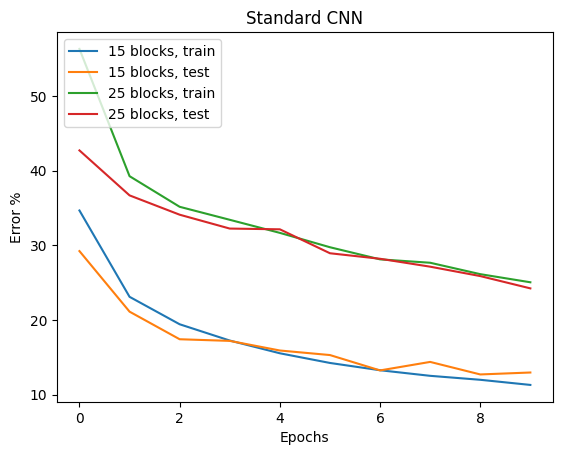

In [10]:
plt.title('Standard CNN')
plt.ylabel('Error %')
plt.xlabel('Epochs')
plt.plot(shallow_standard_train_error)
plt.plot(shallow_standard_test_error)
plt.plot(deep_standard_train_error)
plt.plot(deep_standard_test_error)

plt.legend(['15 blocks, train', '15 blocks, test', '25 blocks, train', '25 blocks, test'], loc='upper left')

plt.show()

In [11]:
shallow_residual_train_error, shallow_residual_test_error = run_experiment(shallow_residual)
deep_residual_train_error, deep_residual_test_error = run_experiment(deep_residual)

Epoch : 1/10, Loss: 0.8583, Validation: 13.78 %
Epoch : 2/10, Loss: 0.3489, Validation: 12.53 %
Epoch : 3/10, Loss: 0.2849, Validation: 10.90 %
Epoch : 4/10, Loss: 0.2499, Validation: 10.66 %
Epoch : 5/10, Loss: 0.2297, Validation: 9.79 %
Epoch : 6/10, Loss: 0.2115, Validation: 9.70 %
Epoch : 7/10, Loss: 0.1996, Validation: 9.74 %
Epoch : 8/10, Loss: 0.1834, Validation: 9.26 %
Epoch : 9/10, Loss: 0.1796, Validation: 9.21 %
Epoch : 10/10, Loss: 0.1669, Validation: 8.88 %
Epoch : 1/10, Loss: 1.0231, Validation: 17.00 %
Epoch : 2/10, Loss: 0.3965, Validation: 12.91 %
Epoch : 3/10, Loss: 0.3234, Validation: 15.11 %
Epoch : 4/10, Loss: 0.2837, Validation: 11.76 %
Epoch : 5/10, Loss: 0.2542, Validation: 10.33 %
Epoch : 6/10, Loss: 0.2327, Validation: 10.98 %
Epoch : 7/10, Loss: 0.2190, Validation: 9.66 %
Epoch : 8/10, Loss: 0.2053, Validation: 9.94 %
Epoch : 9/10, Loss: 0.1988, Validation: 9.86 %
Epoch : 10/10, Loss: 0.1909, Validation: 9.56 %


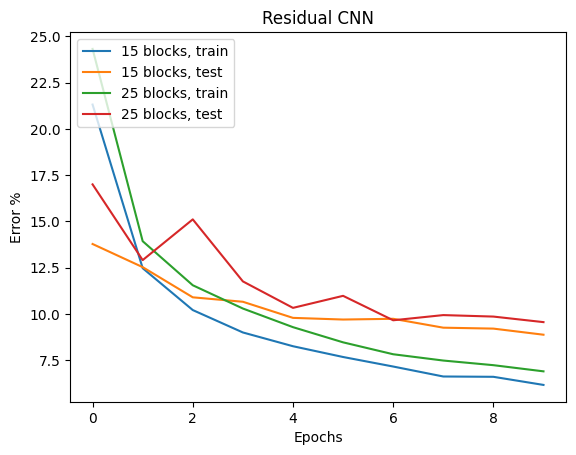

In [12]:
plt.title('Residual CNN')
plt.ylabel('Error %')
plt.xlabel('Epochs')
plt.plot(shallow_residual_train_error)
plt.plot(shallow_residual_test_error)
plt.plot(deep_residual_train_error)
plt.plot(deep_residual_test_error)

plt.legend(['15 blocks, train', '15 blocks, test', '25 blocks, train', '25 blocks, test'], loc='upper left')

plt.show()